<a href="https://colab.research.google.com/github/rodriquiel/sugenoVDA/blob/main/Sugeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sugeno VDA

1. Cargar el conjunto de datos de alguna de las señales de VDA que se ofrecen a continuación y graficarlo.

In [61]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from scipy import interpolate

In [5]:
def load_data(filename):
  data = np.loadtxt(filename)
  return data

In [6]:
data = load_data("/content/samplesVDA1.txt")

In [68]:
sampling_interval = 2.5e-3  # 2.5 ms
time = np.arange(len(data)) * sampling_interval

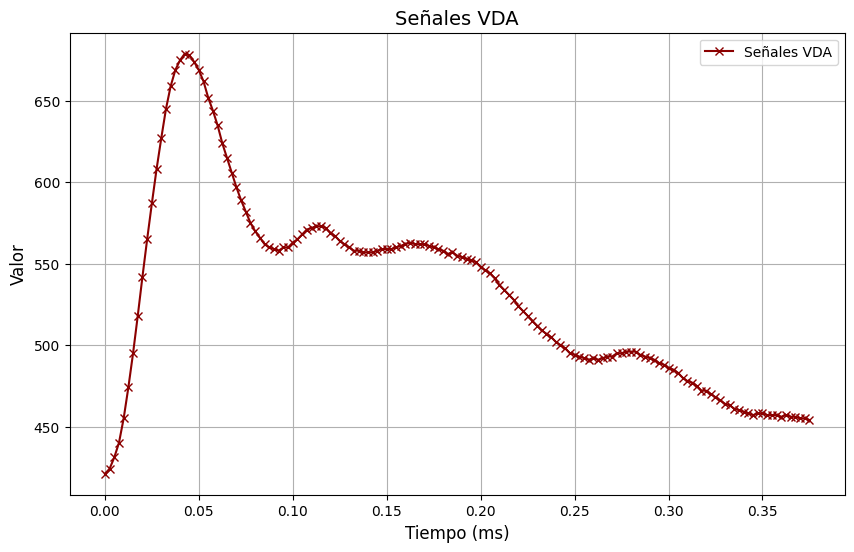

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(time, data, marker='x', color='darkred', label='Señales VDA')

plt.title('Señales VDA', fontsize=14)
plt.xlabel('Tiempo (ms)', fontsize=12)
plt.ylabel('Valor', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

# Clustering substractivo

In [10]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

# c1 = np.random.rand(15,2)+[1,1]
# c2 = np.random.rand(10,2)+[10,1.5]
# c3 = np.random.rand(5,2)+[4.9,5.8]
# m = np.append(c1,c2, axis=0)
# m = np.append(m,c3, axis=0)

# r,c = subclust2(m,2)

# plt.figure()
# plt.scatter(m[:,0],m[:,1])
# plt.scatter(c[:,0],c[:,1], marker='X')
# print(c)

# GEN Fis
## Generación de FIS a partir de agrupamiento de los datos de entrenamiento

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []



    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)

        #print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()






# Entrenamiento modelos Sugeno

In [49]:
def sugeno(data,R):
  sampling_interval = 2.5e-3  # 2.5 ms
  data_x = np.arange(len(data)) * sampling_interval
  data_y = data


  data_t = np.vstack((data_x, data_y)).T
  fis2 = fis()
  fis2.genfis(data_t, R)
  r = fis2.evalfis(np.vstack(data_x))
  MSE = metrics.mean_squared_error(data_y,r)
  return MSE

In [59]:
def sugeno_grafica(data,R):
  sampling_interval = 2.5e-3  # 2.5 ms
  data_x = np.arange(len(data)) * sampling_interval
  data_y = data

  #Grafico señales VDA
  plt.plot(data_x, data_y, marker='x', label='Señales VDA')
  plt.title('Señales VDA', fontsize=14)
  plt.xlabel('Tiempo (ms)', fontsize=12)
  plt.ylabel('Valor', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.show()


  data_t = np.vstack((data_x, data_y)).T
  fis2 = fis()
  fis2.genfis(data_t, R)
  #Grafico funciones gausseanas asociadas al modelo
  fis2.viewInputs()
  r = fis2.evalfis(np.vstack(data_x))

  #Curva real vs Curva predicha
  plt.figure()
  plt.plot(data_x,data_y)
  plt.plot(data_x,r,linestyle='--')

  fis2.solutions
  MSE = metrics.mean_squared_error(data_y,r)
  return MSE

2. Entrenar diferentes modelos de Sugeno con todos ellos, variando la cantidad de reglas R (O el parámetro de radio de vecindad del clustering sustractivo, si corresponde). Graficar el error cuadrático medio (MSE) vs. R.

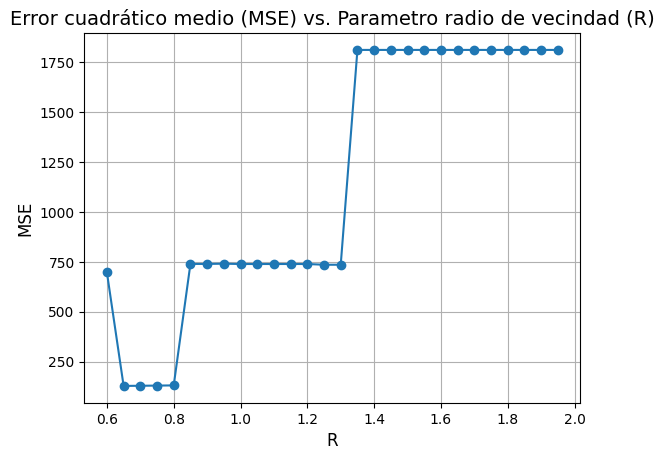

In [51]:
R = 0.6
paso = 0.05
max = 2
tam = (max-R)/paso
data_R = np.zeros(int(tam)+1)
data_MSE = np.zeros(int(tam)+1)
i = 0
min = 1000000
Rmin = 0
while i<=tam:
  data_MSE[i] = sugeno(data,R)
  data_R[i] = R
  if(min>data_MSE[i]):
    min = data_MSE[i]
    Rmin = R
  i+=1
  R+=paso

plt.plot(data_R,data_MSE,marker='o')
plt.title('Error cuadrático medio (MSE) vs. Parametro radio de vecindad (R)', fontsize=14)
plt.xlabel('R', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.grid(True)
plt.show()

Entre 0.65 y 0.8, el MSE se mantiene con un valor bajo y practicamente igual para todos los valores considerados dentro del umbral, pero luego el valor del MSE salta de un valor aproximado de 150 a 750, por lo que se repite la ejecucion pero ahora considerando el umbral entre 0.8 y 0.82, para ver si dentro de este rango puede obtenerse un resultado con un MSE no tan alejado del de 0.8 pero con una menor cantidad de centros de cluster

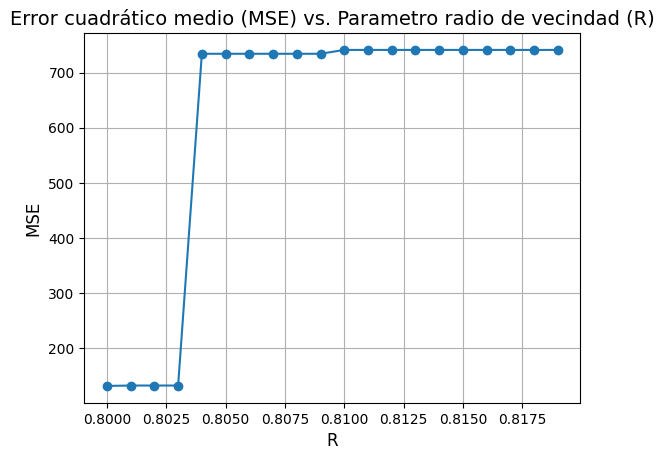

In [52]:
R = 0.8
paso = 0.001
max = 0.82
tam = (max-R)/paso
data_R = np.zeros(int(tam)+1)
data_MSE = np.zeros(int(tam)+1)
i = 0
min = 1000000
Rmin = 0
while i<=tam:
  data_MSE[i] = sugeno(data,R)
  data_R[i] = R
  if(min>data_MSE[i]):
    min = data_MSE[i]
    Rmin = R
  i+=1
  R+=paso

plt.plot(data_R,data_MSE,marker='o')
plt.title('Error cuadrático medio (MSE) vs. Parametro radio de vecindad (R)', fontsize=14)
plt.xlabel('R', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.grid(True)
plt.show()

3. Elegir uno de los modelos según la mejor relación entre R y el MSE obtenido.

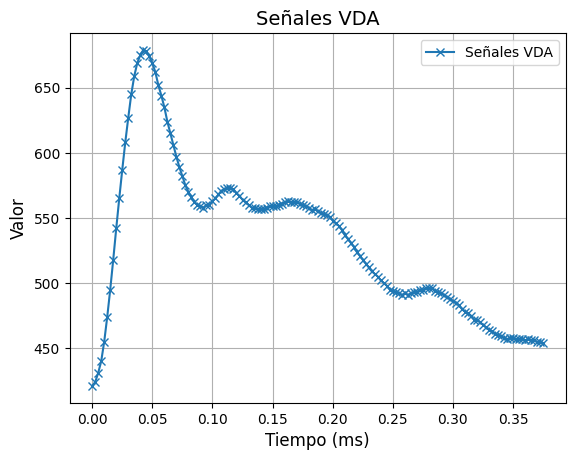

734.1625103163374

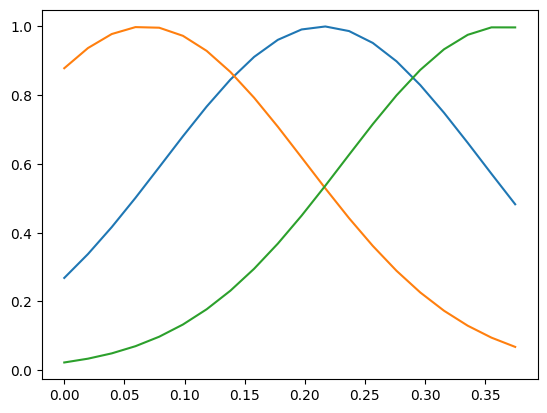

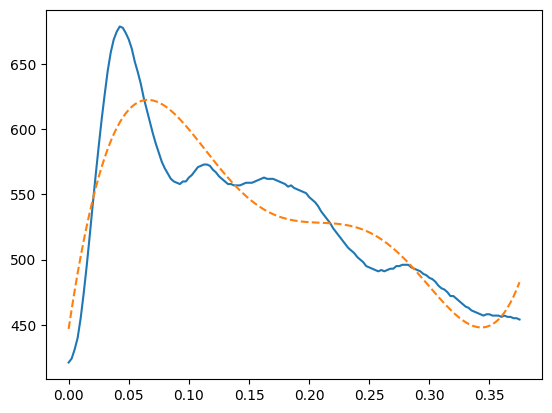

In [60]:
sugeno_grafica(data,0.804)

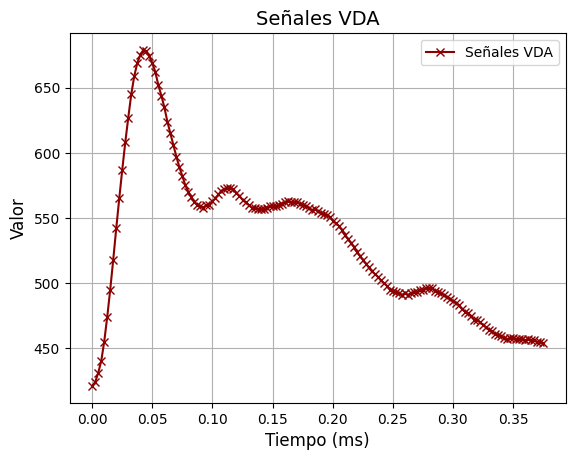

132.5087440159379

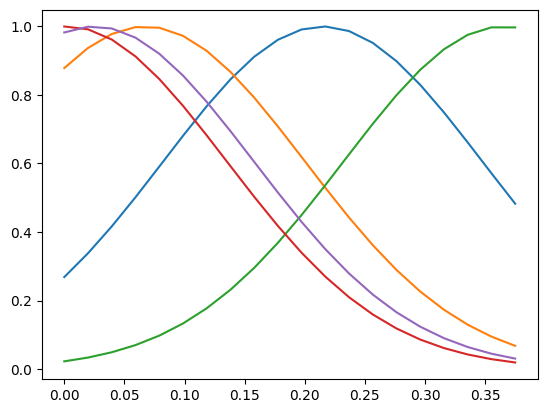

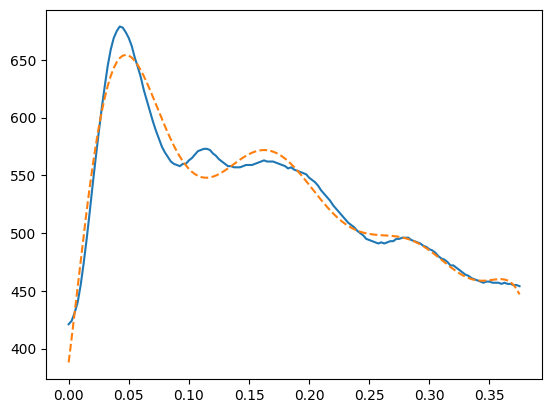

In [58]:
sugeno_grafica(data,0.803)

In [66]:
x = np.arange(len(data))

sobremuestreo_factor = 10
x_new = np.linspace(x.min(), x.max(), len(x) * sobremuestreo_factor)

# Realizar interpolación cúbica
interpolator = interpolate.interp1d(x, data, kind='cubic')
data_sobremuestreada = interpolator(x_new)

4. Sobremuestrear la señal, barriendo la variable de entrada para tener muchos más valores de muestras que con los datos originales y utilizando el modelo de Sugeno seleccionado.

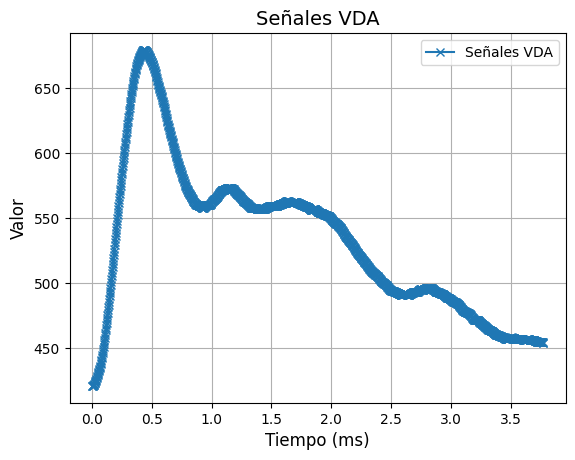

726.9299951720474

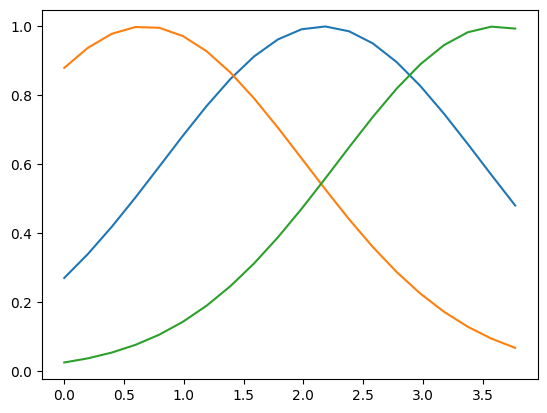

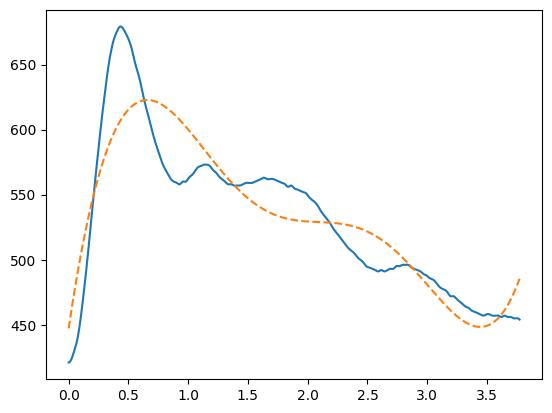

In [63]:
sugeno_grafica(data_sobremuestreada,0.804)

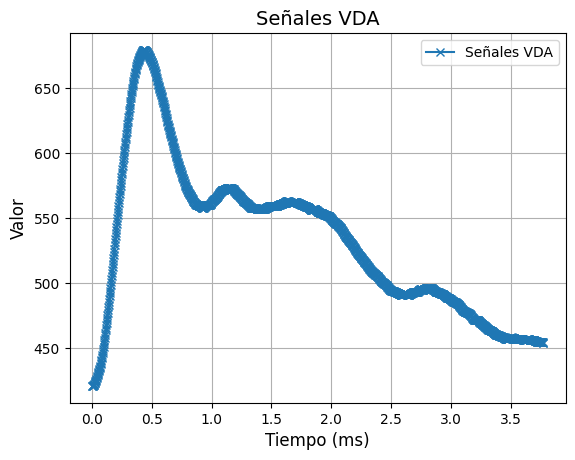

726.9299951720474

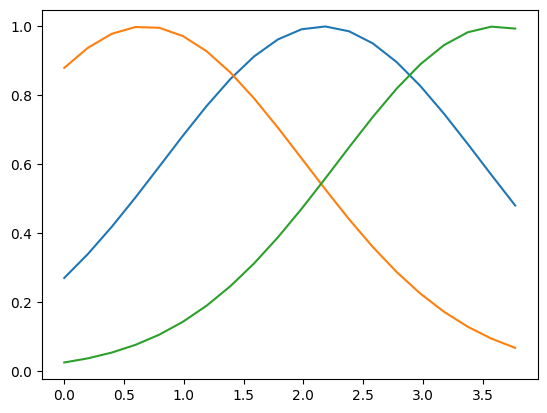

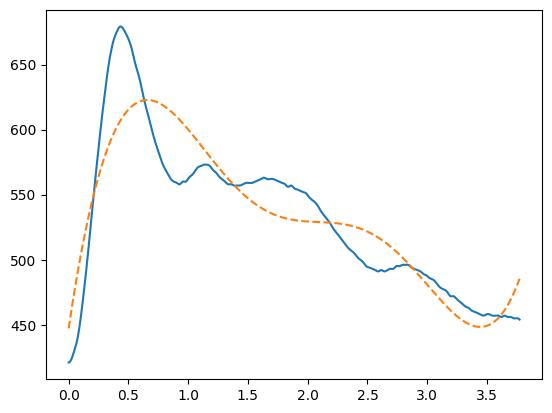

In [65]:
sugeno_grafica(data_sobremuestreada,0.803)